In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics as st

tran = pd.read_csv('transaction_new.csv')
cust = pd.read_csv('customer.csv')
click = pd.read_csv('click_EDA.csv')
churn = pd.read_csv('df_customer_churn.csv')

import csv

f = open('product.csv')
reader = csv.reader(f)
csv_list = []
for i in reader:
    csv_list.append(i)
f.close()
prod = pd.DataFrame(csv_list, columns=['id',
 'gender',
 'masterCategory',
 'subCategory',
 'articleType',
 'baseColour',
 'season',
 'year',
 'usage',
 'productDisplayName',
 'None1',
 'None2']).drop(0)

In [1176]:
tran['join_date'] = tran['customer_id'].map(cust.set_index('customer_id')['first_join_date']) # 가입날짜 매핑
tran['join_date'] = pd.to_datetime(tran['join_date'], format='%Y-%m-%d') # 가입날짜 데이터 타입 변경
tran['created_h'] = tran['created_at'].str[11:19].copy() # 구매 시간 항목 생성
tran['created_at'] = pd.to_datetime(tran['created_at'].astype(str).str[:10], format='%Y-%m-%d').copy() # 구매 날짜 항목 생성 및 데이터 타입 설정
tran['active_day'] = tran['created_at'] - tran['join_date'] # 활동 일자 계산
tran = tran.sort_values(['customer_id','created_at']).reset_index(drop=True) # 데이터 정렬
tran['diff_day'] = tran.groupby('customer_id')['created_at'].diff().fillna(pd.Timedelta(days=0)) # 이전 구매와의 일자 간격
tran['year'] = tran['join_date'].dt.year # 가입 연도 항목 생성
tran['weekday'] = tran['created_at'].dt.strftime('%A') # 요일 항목 생성
prod['id'] = prod['id'].astype(int) # 제품 id 항목 데이터 타입 변경

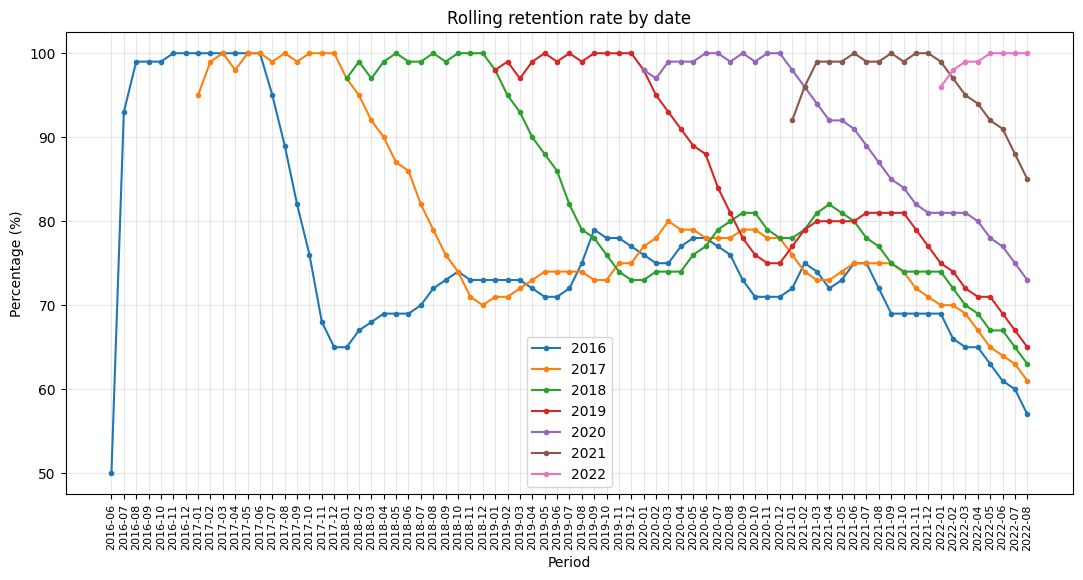

In [625]:
# 최종_리텐션!!!!!
def rolling_retention(df):
  # argument: 
    # df: dataframe
    # year: year number
  r_df_list = []
  period = pd.date_range(start='2016-06-30', end='2022-08-31', freq='M')
  for month in period: 
    
    w0_retention_rate  = []
    for year in range(2016, 2023, 1):
      w0 = df[['customer_id', 'join_date', 'created_at', 'active_day', 'year','diff_day']][(df['year']==year) & (df['join_date']<=pd.to_datetime(month))]['customer_id'].nunique()
      w0_days = df[['customer_id', 'join_date', 'created_at', 'active_day', 'year','diff_day']][(df['year']==year) & (df['created_at']<=pd.to_datetime(month)) & ((pd.to_datetime(month)-df['created_at']) <= pd.Timedelta(days=365))]['customer_id'].nunique()
      if w0 == 0:
        w0 = 1
      w0_retention_rate.append(round(w0_days/w0, 2)*100)
    w_df = pd.DataFrame(w0_retention_rate, columns=[month]).T
    r_df_list.append(w_df)

  r_df = pd.concat(r_df_list, axis=0)
  r_df.columns = range(2016, 2023)
  r_df.index = r_df.index.astype(str).str[:7]
  r_df = r_df.replace(0, np.nan)
  return r_df

rolling_retention(tran)

plt.figure(figsize=(13, 6))
plt.plot(rolling_retention(tran), marker='.', label=rolling_retention(tran).columns)
plt.legend()
plt.grid(alpha=0.3)
plt.title('Rolling retention rate')
plt.xlabel('Period')
plt.xticks(rotation=90, size=8)
plt.ylabel('Percentage (%)')
plt.show()

In [626]:
# 위의 데이터프레임을 정리
retention = rolling_retention(tran)
retention[2016][:12] = np.nan
retention[2017][:18] = np.nan
retention[2018][:30] = np.nan
retention[2019][:42] = np.nan
retention[2020][:54] = np.nan
retention[2021][:66] = np.nan
retention[2022][:74] = np.nan
retention = retention[12:]

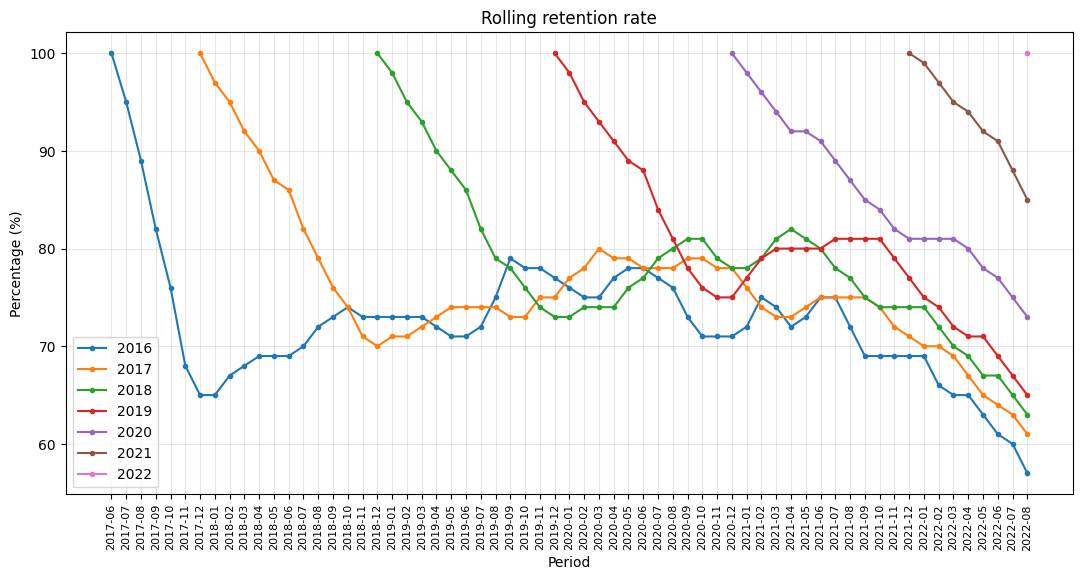

In [627]:
# 정리된 리텐션 그래프
plt.figure(figsize=(13, 6))
plt.plot(retention, marker='.', label=retention.columns)
plt.legend()
plt.grid(alpha=0.3)
plt.title('Rolling retention rate')
plt.xlabel('Period')
plt.xticks(rotation=90, size=8)
plt.ylabel('Percentage (%)')
plt.show()

-----
-----
- 리텐션 그래프를 기반으로 분석

In [1184]:
'''
신규 유저(New User): 제품 사용의 첫 번째 주기에 속한 유저 
현재 유저(Current User): 직전 주기 및 현재 주기 모두 제품을 사용하는 유저
휴면 유저(Dormant User): 현재 주기에 비활성화된 상태이지만, 이전 주기에 제품을 사용한 적이 있는 유저
복귀 유저(Resurrected User): 이전 주기에 휴면 유저였으나 현재 주기에는 다시 제품을 사용하는 유저
    (특히, 복귀 유저는 신규 유저와 구분되어야 하며, 휴면 유저가 되어야만 복귀 유저가 될 수 있습니다.)
'''
# 신규 유저 : c_new
# 현재 유저 : c_active
# 휴면 유저 : c_inactive
# 복귀 유저 : c_return

customer_active = []
for year in range(2016, 2023, 1):
    ids = tran[['customer_id', 'join_date', 'created_at', 'active_day', 'year','diff_day']][(tran['year']==year) & ((pd.to_datetime('2022-08-31')-tran['created_at']) <= pd.Timedelta(days=365))]['customer_id'].unique()
    customer_active.extend(ids)

c_active = tran[tran['customer_id'].isin(customer_active)]
c_inactive = tran[~tran['customer_id'].isin(customer_active)]

c_new = c_active[c_active['year'] == 2022]

c_active = c_active[~(c_active['year'] == 2022)]
# c_active의 고객 중 휴면 기간으로 설정한 365일보다 오래 구매를 하지 않은 고객은 없었다.(최대 339일)
return_ids = c_active[(c_active['active_day'] != pd.Timedelta(days=0)) & (c_active['diff_day'] > pd.Timedelta(days=180))]['customer_id'].unique()
c_return = c_active[c_active['customer_id'].isin(return_ids)]
c_active = c_active[~c_active['customer_id'].isin(return_ids)]

In [1185]:
print('all:', tran.shape[0])
print('active: ', c_active.shape[0])
print('inactive: ', c_inactive.shape[0])
print('new: ', c_new.shape[0])
print('return: ', c_return.shape[0])
print('sum: ', c_active.shape[0] + c_inactive.shape[0] + c_new.shape[0] + c_return.shape[0])

all: 1254585
active:  1125498
inactive:  34776
new:  56199
return:  38112
sum:  1254585


In [650]:
# # tran 파일에 고객 상태 항목 추가
# tran.loc[tran['customer_id'].isin(c_active['customer_id'].unique()), 'user_status'] = 'active'
# tran.loc[tran['customer_id'].isin(c_inactive['customer_id'].unique()), 'user_status'] = 'inactive'
# tran.loc[tran['customer_id'].isin(c_return['customer_id'].unique()), 'user_status'] = 'return'
# tran.loc[tran['customer_id'].isin(c_new['customer_id'].unique()), 'user_status'] = 'new'

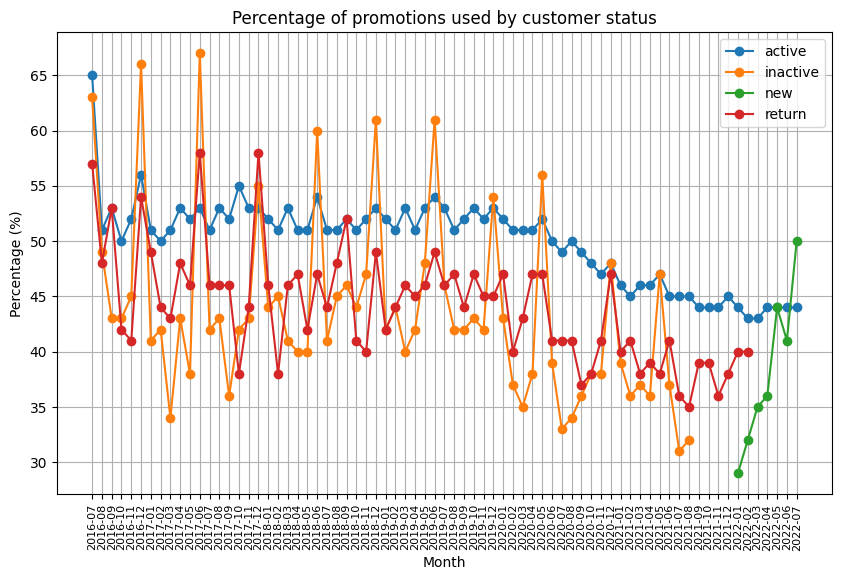

In [396]:
# 가입자별 promo 사용 비율(프로모션 사용한 고객 수 / 해당 시점의 고객 수)
def promo_count_rate(df):

    promo_count = df[~((df['diff_day'] == pd.Timedelta(days=0)) & (df['customer_id'].diff() == 0))].copy() # 프로모션 중복 항목 제거
    promo_count['created_m'] = promo_count['created_at'].astype(str).str[:7]
    
    # 프로모션코드를 적용한 기록의 customer_id의 수
    yearly_counts = promo_count[~promo_count['promo_code'].isnull()].groupby(['created_m'])['customer_id'].nunique()
    # 기간별 모든 customer_id의 수
    customer_counts = promo_count.groupby(['created_m'])['customer_id'].nunique()
    # 프로모션코드를 적용한 기록의 비율을 계산
    result = round(yearly_counts / customer_counts,2) *100

    # 2016-06 은 첫 시작 달이기 때문에 0 혹은 0에 가까운 숫자가 나온다. 분석에 큰 영향이 없으므로 삭제
    if '2016-06' in result.index:
        result.drop('2016-06', inplace=True)

    return result

promo_count_rate(c_inactive)

plt.figure(figsize=(10, 6))

plt.plot(promo_count_rate(c_active).index, promo_count_rate(c_active), marker='o', label='active')
plt.plot(promo_count_rate(c_inactive).index, promo_count_rate(c_inactive), marker='o', label='inactive')
plt.plot(promo_count_rate(c_new).index, promo_count_rate(c_new), marker='o', label='new')
plt.plot(promo_count_rate(c_return).index, promo_count_rate(c_return), marker='o', label='return')

plt.xlabel('Month')
plt.xticks(rotation=90, size=8)
plt.ylabel('Percentage (%)')
plt.title('Percentage of promotions used by customer status')
plt.legend(loc='upper right')
plt.grid()
plt.show()

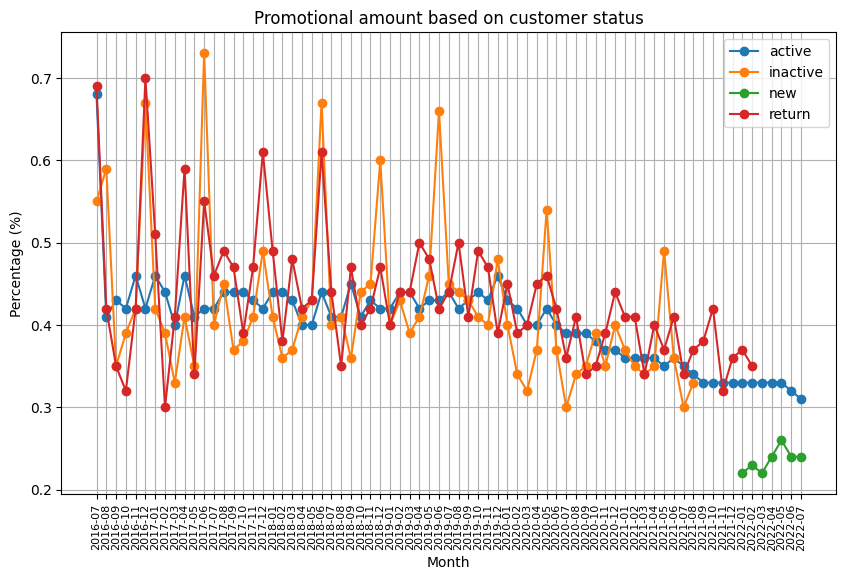

In [84]:
# 가입자별 promo 사용 액수(프로모션 액수 / 총 구매 액수)
def promo_amount(df):

    promo_count = df[~((df['diff_day'] == pd.Timedelta(days=0)) & (df['customer_id'].diff() == 0))].copy() # 프로모션 중복 항목 제거
    promo_count['created_m'] = promo_count['created_at'].astype(str).str[:7]
    
    # 프로모션코드를 적용한 기록의 프로모션 액수의 합
    yearly_sum = promo_count[~promo_count['promo_code'].isnull()].groupby(['created_m'])['promo_amount'].sum()
    # 기간별 모든 구매 액수의 합
    customer_sum = promo_count.groupby(['created_m'])['total_amount'].sum() + yearly_sum
    # 프로모션코드를 적용한 기록의 비율을 계산
    result = round(yearly_sum / customer_sum,4) *100

    # 2016-06 은 첫 시작 달이기 때문에 0 혹은 0에 가까운 숫자가 나온다. 분석에 큰 영향이 없으므로 삭제
    if '2016-06' in result.index:
        result.drop('2016-06', inplace=True)

    return result

promo_amount(c_inactive)

plt.figure(figsize=(10, 6))

plt.plot(promo_amount(c_active).index, promo_amount(c_active), marker='o', label='active')
plt.plot(promo_amount(c_inactive).index, promo_amount(c_inactive), marker='o', label='inactive')
plt.plot(promo_amount(c_new).index, promo_amount(c_new), marker='o', label='new')
plt.plot(promo_amount(c_return).index, promo_amount(c_return), marker='o', label='return')

plt.xlabel('Month')
plt.xticks(rotation=90, size=8)
plt.ylabel('Percentage (%)')
plt.title('Promotional amount based on customer status')
plt.legend(loc='upper right')
plt.grid()
plt.show()

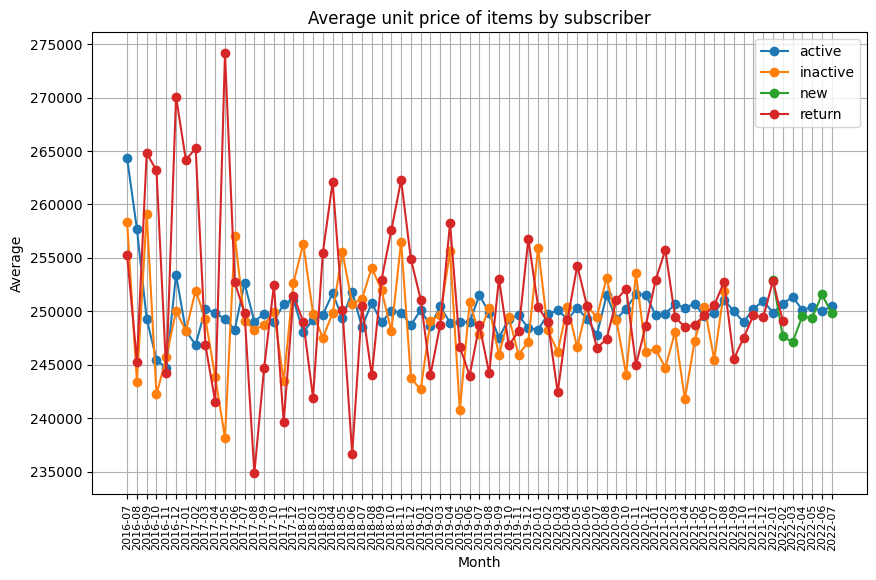

In [392]:
# 가입자별 아이템 단가 평균

def item_price(df):

    promo_count = df.copy()
    promo_count['created_m'] = promo_count['created_at'].astype(str).str[:7]
    
    # 아이템 금액 평균
    item_price = promo_count.groupby('created_m')['item_price'].mean() # 산술평균
    # item_price = promo_count.groupby('created_m')['item_price'].apply(g_mean) # 기하평균

    # 2016-06 은 첫 시작 달이기 때문에 0 혹은 0에 가까운 숫자가 나온다. 분석에 큰 영향이 없으므로 삭제
    if '2016-06' in item_price.index:
        item_price.drop('2016-06', inplace=True)

    return item_price

item_price(c_inactive)

plt.figure(figsize=(10, 6))

plt.plot(item_price(c_active).index, item_price(c_active), marker='o', label='active')
plt.plot(item_price(c_inactive).index, item_price(c_inactive), marker='o', label='inactive')
plt.plot(item_price(c_new).index, item_price(c_new), marker='o', label='new')
plt.plot(item_price(c_return).index, item_price(c_return), marker='o', label='return')

plt.xlabel('Month')
plt.xticks(rotation=90, size=8)
plt.ylabel('Average')
plt.title('Average unit price of items by subscriber')
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [1236]:
# 가입자별 1회 구매(같은 세션안에서의 갯수 혹은 아이템별 갯수) 아이템 갯수 평균
# 아이템별 갯수
def item_quan(df):

    promo_count = df.copy()
    promo_count['created_m'] = promo_count['created_at'].astype(str).str[:7]
    
    # 아이템 금액 평균
    item_quan = promo_count.groupby('created_m')['quantity'].mean()

    # 2016-06 은 첫 시작 달이기 때문에 0 혹은 0에 가까운 숫자가 나온다. 분석에 큰 영향이 없으므로 삭제
    if '2016-06' in item_quan.index:
        item_quan.drop('2016-06', inplace=True)

    return item_quan

# booking_id별 갯수
def item_quan_book(df):

    booking_ids = df[df.eq(df.shift())['booking_id']]['booking_id'].unique()
    once_lot = df[df['booking_id'].isin(booking_ids)].groupby('booking_id')['quantity'].sum() # 한 번에 여러 아이템을 많이 산 booking_id
    once_one = df[~df['booking_id'].isin(booking_ids)].groupby('booking_id')['quantity'].sum() # 나머지 booking_id
    once = pd.concat([once_lot, once_one], axis=0)

    quan_book = df.copy()
    quan_book['once_quan'] = quan_book['booking_id'].map(once)
    result = quan_book[~quan_book['booking_id'].duplicated()].copy()
    result['created_m'] = result['created_at'].astype(str).str[:7]
    result = result.groupby('created_m')['once_quan'].mean()

    # 2016-06 은 첫 시작 달이기 때문에 0 혹은 0에 가까운 숫자가 나온다. 분석에 큰 영향이 없으므로 삭제
    if '2016-06' in result.index:
        result.drop('2016-06', inplace=True)

    return result

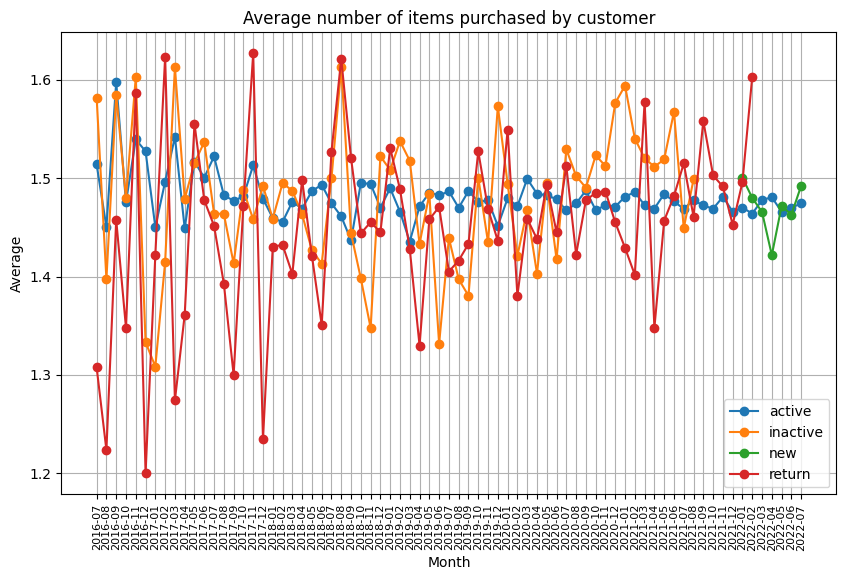

In [223]:
# 아이템 구매 갯수
plt.figure(figsize=(10, 6))

plt.plot(item_quan(c_active).index, item_quan(c_active), marker='o', label='active')
plt.plot(item_quan(c_inactive).index, item_quan(c_inactive), marker='o', label='inactive')
plt.plot(item_quan(c_new).index, item_quan(c_new), marker='o', label='new')
plt.plot(item_quan(c_return).index, item_quan(c_return), marker='o', label='return')

plt.xlabel('Month')
plt.xticks(rotation=90, size=8)
plt.ylabel('Average')
plt.title('Average number of items purchased by customer')
plt.legend(loc='lower right')
plt.grid()
plt.show()

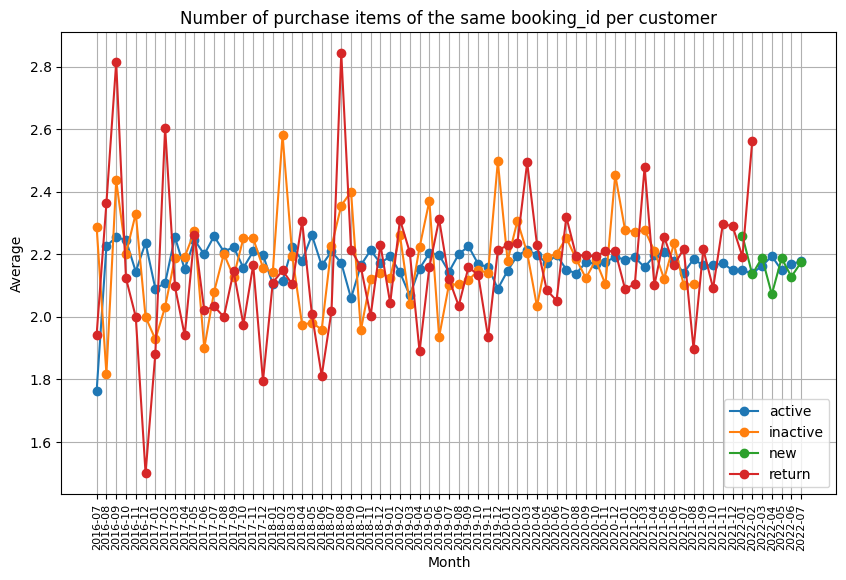

In [227]:
# 1회 구매시 구매하는 아이템의 총 갯수(booking_id 기준)
plt.figure(figsize=(10, 6))

plt.plot(item_quan_book(c_active).index, item_quan_book(c_active), marker='o', label='active')
plt.plot(item_quan_book(c_inactive).index, item_quan_book(c_inactive), marker='o', label='inactive')
plt.plot(item_quan_book(c_new).index, item_quan_book(c_new), marker='o', label='new')
plt.plot(item_quan_book(c_return).index, item_quan_book(c_return), marker='o', label='return')

plt.xlabel('Month')
plt.xticks(rotation=90, size=8)
plt.ylabel('Average')
plt.title('Number of purchase items of the same booking_id per customer')
plt.legend(loc='lower right')
plt.grid()
plt.show()

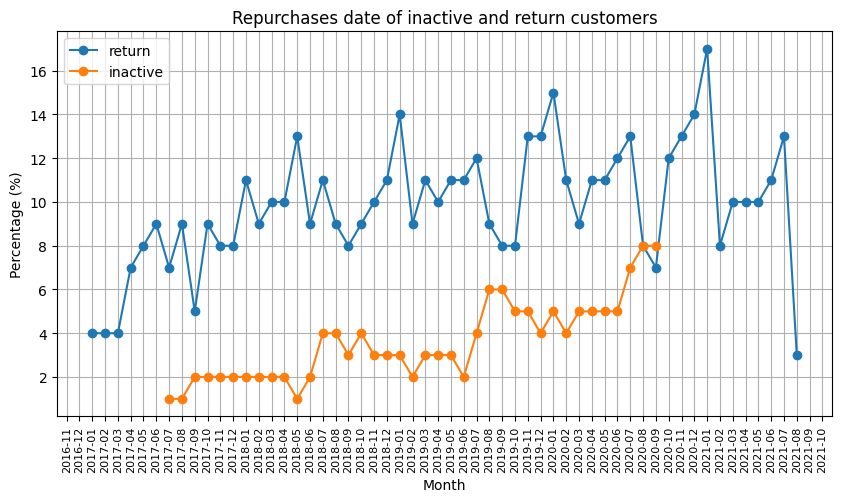

In [1179]:
# inactive, return 고객의 재구매 날짜
def customer_count(df):

    re_purchase = df[(df['customer_id'].diff() == 0) & (df['created_at'].diff() > pd.Timedelta(days=0))].copy() # 재구매 정보
    re_purchase['created_m'] = re_purchase['created_at'].astype(str).str[:7]
    re_purchase['join_m'] = re_purchase['join_date'].astype(str).str[:7]
    
    # 날짜별 고객 count
    all_customer = re_purchase.groupby('join_m')['customer_id'].nunique()
    for i in range(1, len(all_customer)):
        all_customer[i] += all_customer[i-1]
    
    count_customer = re_purchase.groupby('created_m')['customer_id'].nunique()
    customer_rate = round(count_customer / all_customer, 2) *100

    month_list = []
    for i in pd.date_range(start='2016-06', end='2022-08', freq='M'):
        month_list.append(i.strftime('%Y-%m'))
    
    month_list = pd.DataFrame(month_list, columns=['month'])
    month_list['count_customer'] = month_list['month'].map(customer_rate)
    month_list = month_list.set_index('month')

    return month_list

customer_count(c_return)

plt.figure(figsize=(10, 5))

plt.plot(customer_count(c_return).index, customer_count(c_return), marker='o', label='return', color='tab:blue')
plt.plot(customer_count(c_inactive).index, customer_count(c_inactive), marker='o', label='inactive', color='tab:orange')
# plt.plot(customer_count(c_active).index, customer_count(c_active), marker='o', label='active', color='tab:green')
# plt.plot(customer_count(c_new).index, customer_count(c_new), marker='o', label='return', color='tab:purple')

plt.xlabel('Month')
plt.xticks(rotation=90, size=8)
plt.ylabel('Percentage (%)')
plt.title('Repurchases date of inactive and return customers')
plt.legend(loc='upper left')
plt.grid()
plt.show()

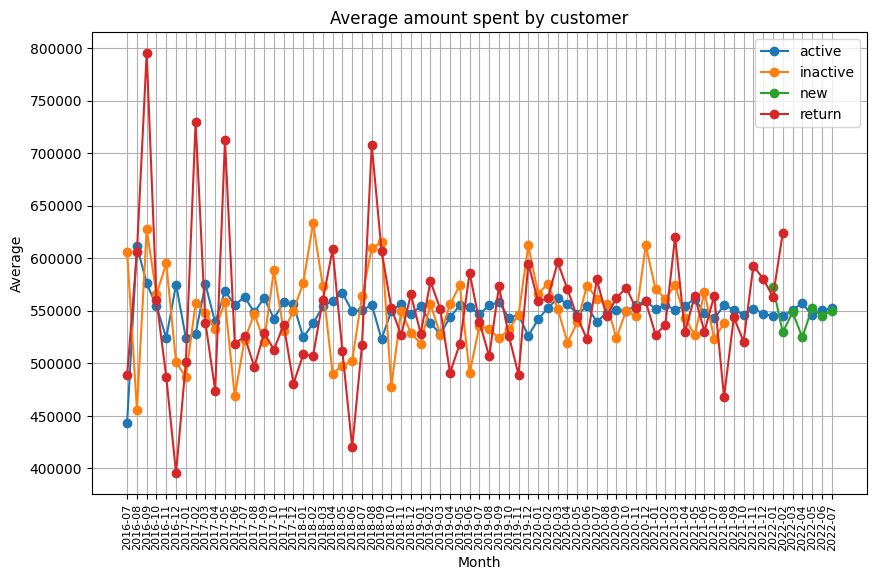

In [410]:
# 1회 지출 금액 평균(total_amount = 배송비포함, 프로모션 적용)
def total_price(df):
    
    total_amount = df[~((df['diff_day'] == pd.Timedelta(days=0)) & (df['customer_id'].diff() == 0))].copy() # total_amount 중복 항목 제거
    total_amount['created_m'] = total_amount['created_at'].astype(str).str[:7]
    
    # 금액 평균
    result = total_amount.groupby(['created_m'])['total_amount'].mean()

    # 2016-06 은 첫 시작 달이기 때문에 0 혹은 0에 가까운 숫자가 나온다. 분석에 큰 영향이 없으므로 삭제
    if '2016-06' in result.index:
        result.drop('2016-06', inplace=True)

    return result

total_price(c_active)

plt.figure(figsize=(10, 6))

plt.plot(total_price(c_active).index, total_price(c_active), marker='o', label='active')
plt.plot(total_price(c_inactive).index, total_price(c_inactive), marker='o', label='inactive')
plt.plot(total_price(c_new).index, total_price(c_new), marker='o', label='new')
plt.plot(total_price(c_return).index, total_price(c_return), marker='o', label='return')

plt.xlabel('Month')
plt.xticks(rotation=90, size=8)
plt.ylabel('Average')
plt.title('Average amount spent by customer')
plt.legend(loc='upper right')
plt.grid()
plt.show()

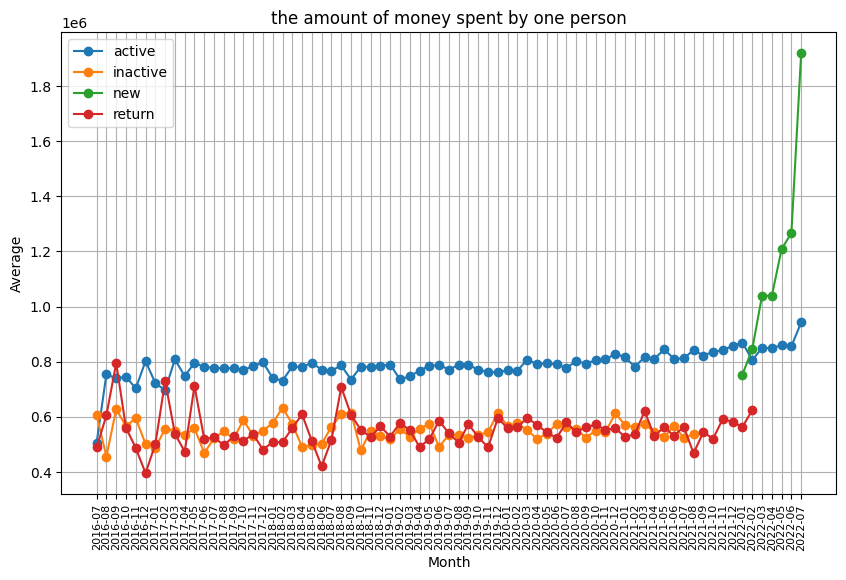

In [360]:
# 가입자별 인당 지출 금액(total_amount = 배송비포함, 프로모션 적용)
def person_amount(df):
    
    total_amount = df[~((df['diff_day'] == pd.Timedelta(days=0)) & (df['customer_id'].diff() == 0))].copy() # total_amount 중복 항목 제거
    total_amount['created_m'] = total_amount['created_at'].astype(str).str[:7]
    
    sum_amount = total_amount.groupby('created_m')['total_amount'].sum()
    customer = total_amount.groupby('created_m')['customer_id'].nunique()

    result = sum_amount / customer

    # 2016-06 은 첫 시작 달이기 때문에 0 혹은 0에 가까운 숫자가 나온다. 분석에 큰 영향이 없으므로 삭제
    if '2016-06' in result.index:
        result.drop('2016-06', inplace=True)

    return result

person_amount(c_active)

plt.figure(figsize=(10, 6))

plt.plot(person_amount(c_active).index, person_amount(c_active), marker='o', label='active')
plt.plot(person_amount(c_inactive).index, person_amount(c_inactive), marker='o', label='inactive')
plt.plot(person_amount(c_new).index, person_amount(c_new), marker='o', label='new')
plt.plot(person_amount(c_return).index, person_amount(c_return), marker='o', label='return')

plt.xlabel('Month')
plt.xticks(rotation=90, size=8)
plt.ylabel('Average')
plt.title('the amount of money spent by one person')
plt.legend(loc='upper left')
plt.grid()
plt.show()

---
---

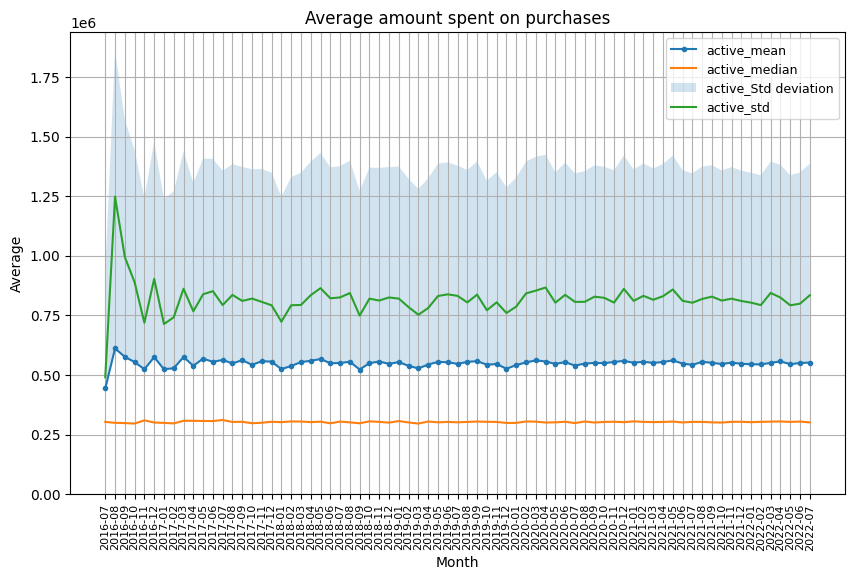

In [503]:
# 1회 지출 금액 평균(total_amount = 배송비포함, 프로모션 적용)
def total_price(df):
    
    total_amount = df[~((df['diff_day'] == pd.Timedelta(days=0)) & (df['customer_id'].diff() == 0))].copy() # total_amount 중복 항목 제거
    total_amount['created_m'] = total_amount['created_at'].astype(str).str[:7]
    
    result = total_amount.groupby(['created_m'])['total_amount']

    return result

total_price(c_active).max()

plt.figure(figsize=(10, 6))

plt.plot(total_price(c_active).mean().index, total_price(c_active).mean(), marker='.', label='active_mean')
plt.plot(total_price(c_active).mean().index, total_price(c_active).median(), label='active_median')
plt.fill_between(total_price(c_active).mean().index, total_price(c_active).mean(), total_price(c_active).mean()+total_price(c_active).std(), alpha=0.2,label='active_Std deviation')
plt.plot(total_price(c_active).mean().index, total_price(c_active).std(), label='active_std')

# plt.plot(total_price(c_new).mean().index, total_price(c_new).mean(), marker='o', label='new_mean')
# plt.plot(total_price(c_new).mean().index, total_price(c_new).median(), marker='o', label='new_median')
# plt.fill_between(total_price(c_new).mean().index, total_price(c_new).mean()-total_price(c_new).std(), total_price(c_new).mean()+total_price(c_new).std(), alpha=0.2,label='new_Std deviation')
# plt.plot(total_price(c_new).mean().index, total_price(c_new).std(), marker='o', label='new_std')

plt.xlabel('Month')
plt.xticks(rotation=90, size=8)
plt.ylabel('Average')
plt.ylim(0)
plt.title('Average amount spent on purchases')
plt.legend(loc='upper right', prop={'size':9})
plt.grid()
plt.show()

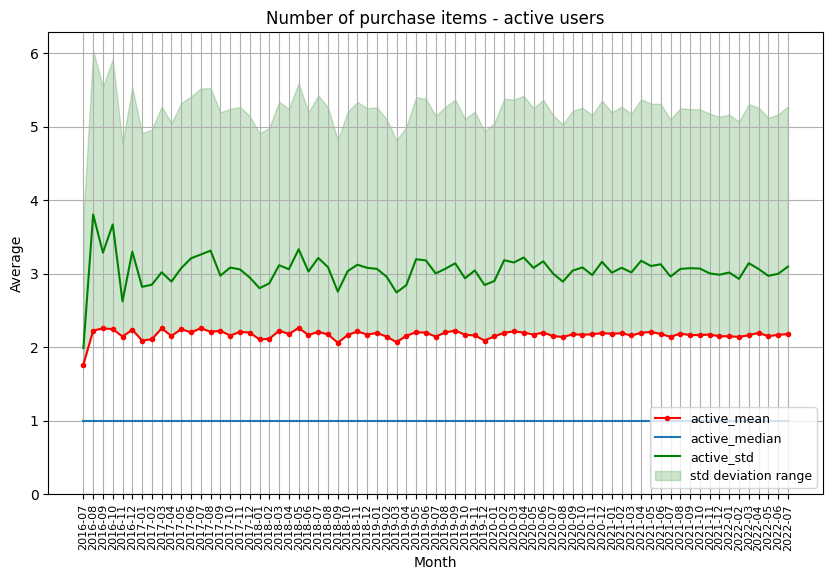

None

In [1237]:
# booking_id별 갯수
def item_quan_book(df):
    
    # booking_id별 quantity 합계 구하기
    booking_ids = df[df.eq(df.shift())['booking_id']]['booking_id'].unique() # 이전 인덱스와 같은 booking_id
    once_lot = df[df['booking_id'].isin(booking_ids)].groupby('booking_id')['quantity'].sum() # 한 번에 여러 아이템을 많이 산 booking_id
    once_one = df[~df['booking_id'].isin(booking_ids)].groupby('booking_id')['quantity'].sum() # 나머지 booking_id
    once = pd.concat([once_lot, once_one], axis=0)

    quan_book = df.copy()
    quan_book['once_quan'] = quan_book['booking_id'].map(once)
    result = quan_book[~quan_book['booking_id'].duplicated()].copy()
    result['created_m'] = result['created_at'].astype(str).str[:7]

    result_mean = result.groupby('created_m')['once_quan'].mean()
    result_median = result.groupby('created_m')['once_quan'].median()
    result_std = result.groupby('created_m')['once_quan'].std()

    # 2016-06 은 첫 시작 달이기 때문에 0 혹은 0에 가까운 숫자가 나온다. 분석에 큰 영향이 없으므로 삭제
    for results in [result_mean, result_median, result_std]:
        if '2016-06' in results.index:
            results.drop('2016-06', inplace=True)

    return result_mean, result_median, result_std

def visualize(df, function_df, title):
    df_mean, df_median, df_std = function_df
    df_name = [name for name in globals() if globals()[name] is df][0][2:]

    # 1회 구매시 구매하는 아이템의 총 갯수(booking_id 기준)
    plt.figure(figsize=(10, 6))

    plt.plot(df_mean.index, df_mean, marker='.', label=f'{df_name}_mean', c='red')
    plt.plot(df_median.index, df_median, label=f'{df_name}_median')
    plt.plot(df_std.index, df_std, label=f'{df_name}_std', c='green')
    plt.fill_between(df_std.index, df_mean, df_mean+df_std, color='green', alpha=0.2, label=f'std deviation range')

    plt.xlabel('Month')
    plt.xticks(rotation=90, size=8)
    plt.ylabel('Average')
    plt.ylim(0)
    plt.title(f'{title} - {df_name} users')
    plt.legend(loc='lower right', prop={'size':9})
    plt.grid()
    plt.show()

display(visualize(c_active, item_quan_book(c_active), 'Number of purchase items'))
# display(visualize(c_inactive, item_quan_book(c_inactive), 'Number of purchase items'))
# display(visualize(c_new, item_quan_book(c_new), 'Number of purchase items'))
# display(visualize(c_return, item_quan_book(c_return), 'Number of purchase items'))

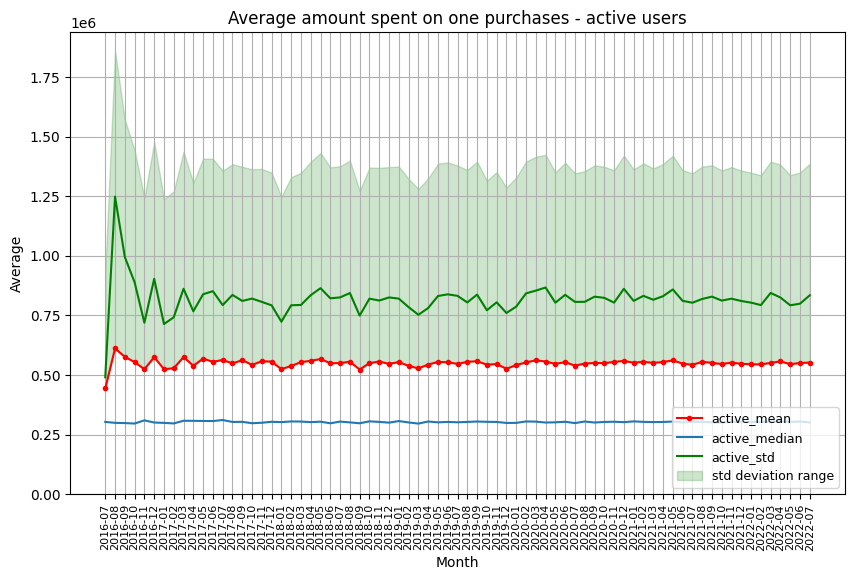

None

In [1238]:
# 1회 지출 금액 평균(total_amount = 배송비포함, 프로모션 적용)
def total_price(df):
    
    total_amount = df[~((df['diff_day'] == pd.Timedelta(days=0)) & (df['customer_id'].diff() == 0))].copy() # total_amount 중복 항목 제거
    total_amount['created_m'] = total_amount['created_at'].astype(str).str[:7]
    
    result = total_amount.groupby(['created_m'])['total_amount']

    result_mean = result.mean()
    result_median = result.median()
    result_std = result.std()

    # 2016-06 은 첫 시작 달이기 때문에 0 혹은 0에 가까운 숫자가 나온다. 분석에 큰 영향이 없으므로 삭제
    for results in [result_mean, result_median, result_std]:
        if '2016-06' in results.index:
            results.drop('2016-06', inplace=True)

    return result_mean, result_median, result_std

display(visualize(c_active, total_price(c_active), 'Average amount spent on one purchases'))
# display(visualize(c_inactive, total_price(c_inactive), 'Average amount spent on one purchases'))
# display(visualize(c_new, total_price(c_new), 'Average amount spent on one purchases'))
# display(visualize(c_return, total_price(c_return), 'Average amount spent on one purchases'))

In [ ]:
# 가입자별 아이템 단가 평균

def item_price(df):

    promo_count = df.copy()
    promo_count['created_m'] = promo_count['created_at'].astype(str).str[:7]
    
    # 월별 itme_price
    item_price = promo_count.groupby('created_m')['item_price']

    result_mean = item_price.mean()
    result_median = item_price.median()
    result_std = item_price.std()

    # 2016-06 은 첫 시작 달이기 때문에 0 혹은 0에 가까운 숫자가 나온다. 분석에 큰 영향이 없으므로 삭제
    for results in [result_mean, result_median, result_std]:
        if '2016-06' in results.index:
            results.drop('2016-06', inplace=True)

    return result_mean, result_median, result_std

def visualize_minusstd(df, function_df, title):
    df_mean, df_median, df_std = function_df
    df_name = [name for name in globals() if globals()[name] is df][0][2:]

    # 1회 구매시 구매하는 아이템의 총 갯수(booking_id 기준)
    plt.figure(figsize=(10, 6))

    plt.plot(df_mean.index, df_mean, marker='.', label=f'{df_name}_mean', c='red')
    plt.plot(df_median.index, df_median, label=f'{df_name}_median')
    plt.plot(df_std.index, df_std, label=f'{df_name}_std deviation', c='green')
    plt.fill_between(df_std.index, df_mean-df_std, df_mean+df_std, color='green', alpha=0.2, label=f'std deviation range')

    plt.xlabel('Month')
    plt.xticks(rotation=90, size=8)
    plt.ylabel('Average')
    plt.ylim(0)
    plt.title(f'{title} - {df_name} users')
    plt.legend(loc='lower right', prop={'size':9})
    plt.grid()
    plt.show()

display(visualize_minusstd(c_active, item_price(c_active), 'Average unit price of items'))
# display(visualize_minusstd(c_inactive, item_price(c_inactive), 'Average unit price of items'))
# display(visualize_minusstd(c_new, item_price(c_new), 'Average unit price of items'))
# display(visualize_minusstd(c_return, item_price(c_return), 'Average unit price of items'))

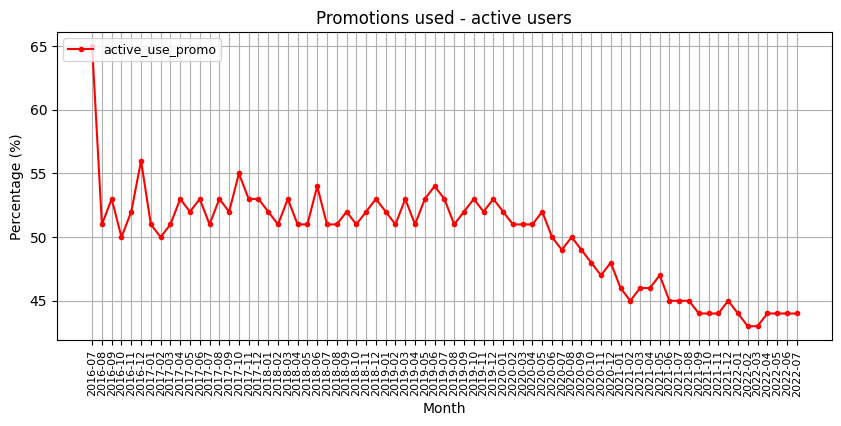

In [1239]:
# 가입자별 promo 사용 비율(프로모션 사용한 고객 수 / 해당 시점의 고객 수)
def promo_count_rate(df):

    promo_count = df[~((df['diff_day'] == pd.Timedelta(days=0)) & (df['customer_id'].diff() == 0))].copy() # 프로모션 중복 항목 제거
    promo_count['created_m'] = promo_count['created_at'].astype(str).str[:7]
    
    # 프로모션코드를 적용한 기록의 customer_id의 수
    promo_counts = promo_count[~promo_count['promo_code'].isnull()].groupby(['created_m'])['customer_id'].nunique()
    # 기간별 모든 customer_id의 수
    customer_counts = promo_count.groupby(['created_m'])['customer_id'].nunique()
    # 프로모션코드를 적용한 기록의 비율을 계산
    result = round(promo_counts / customer_counts,2) *100

    # 2016-06 은 첫 시작 달이기 때문에 0 혹은 0에 가까운 숫자가 나온다. 분석에 큰 영향이 없으므로 삭제
    for results in [promo_counts, customer_counts, result]:
        if '2016-06' in results.index:
            results.drop('2016-06', inplace=True)

    return promo_counts, customer_counts, result

def visualize_promo(df, function_df, title):
    promo_counts, customer_counts, result = function_df
    df_name = [name for name in globals() if globals()[name] is df][0][2:]

    # 1회 구매시 구매하는 아이템의 총 갯수(booking_id 기준)
    plt.figure(figsize=(10, 4))

    plt.plot(promo_counts.index, result, marker='.', label=f'{df_name}_use_promo', c='red')

    plt.xlabel('Month')
    plt.xticks(rotation=90, size=8)
    plt.ylabel('Percentage (%)')
    plt.title(f'{title} - {df_name} users')
    plt.legend(loc='upper left', prop={'size':9})
    plt.grid()
    plt.show()

visualize_promo(c_active, promo_count_rate(c_active), 'Promotions used')
# visualize_promo(c_inactive, promo_count_rate(c_inactive), 'Promotions used')
# visualize_promo(c_new, promo_count_rate(c_new), 'Promotions used')
# visualize_promo(c_return, promo_count_rate(c_return), 'Promotions used')

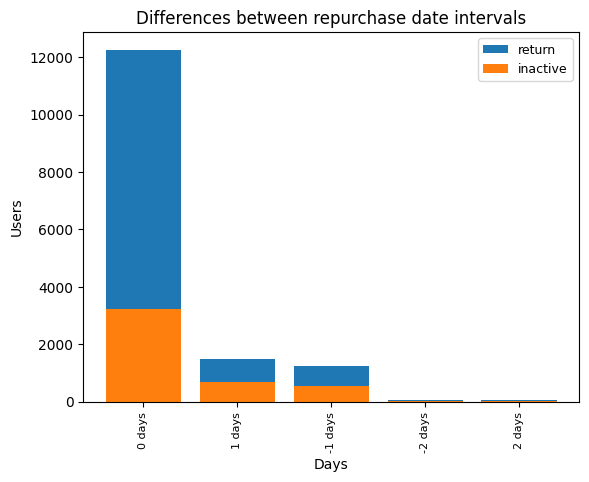

In [861]:
# 3회 이상 구매한 고객들의 재구매 날짜 간격 확인
def check_day_diff(df):
    repurchase = df[(df['customer_id'].diff() == 0) & (df['diff_day'] != pd.Timedelta(days=0))]
    three_times_ids = repurchase[repurchase['customer_id'].duplicated(keep=False)]['customer_id'].unique()
    three_times = df[df['customer_id'].isin(three_times_ids)]
    three_times = three_times[(three_times['customer_id'].diff() == 0) & (three_times['diff_day'] != pd.Timedelta(days=0))]
    repurchase_days_diff = pd.DataFrame({
        'customer_id_diff': three_times['customer_id'].diff(),
        'diff_day_diff': three_times['diff_day'].diff()
    })
    result = repurchase_days_diff[repurchase_days_diff['customer_id_diff'] == 0]['diff_day_diff'].value_counts()
    return result

check_day_diff(c_inactive)
check_day_diff(c_return).index.astype(str)

plt.bar(check_day_diff(c_return).index.astype(str), check_day_diff(c_return), label='return')
plt.bar(check_day_diff(c_inactive).index.astype(str), check_day_diff(c_inactive), label='inactive')

plt.xlabel('Days')
plt.xticks(rotation=90, size=8)
plt.ylabel('Users')
plt.ylim(0)
plt.title('Differences between repurchase date intervals')
plt.legend(loc='upper right', prop={'size':9})
plt.show()

return: ['AZ2022', 'BUYMORE', 'WEEKENDSERU', 'XX2022', 'WEEKENDMANTAP', 'LIBURDONG', 'STARTUP', 'SC2022']


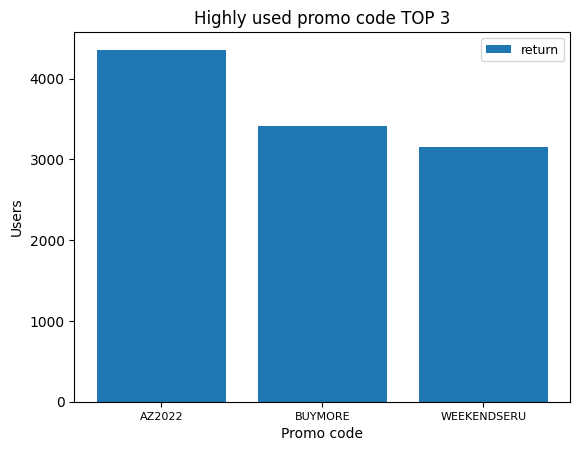

In [1211]:
def promo_top(df):
    promo_top = df[~((df['diff_day'] == pd.Timedelta(days=0)) & (df['customer_id'].diff() == 0))].copy() # 프로모션 중복 항목 제거

    result = df['promo_code'].value_counts()

    return result

def viz_promo_top(df):
    df_name = [name for name in globals() if globals()[name] is df][0][2:]

    print(f'{df_name}:', list(df['promo_code'].value_counts().index))

    if df_name == 'inactive':
        color = 'tab:orange'
    elif df_name == 'return':
        color = 'tab:blue'
    elif df_name == 'active':
        color = 'tab:green'
    elif df_name == 'new':
        color = 'tab:purple'

    plt.bar(promo_top(df).index[:3], promo_top(df)[:3], label=df_name, color=color)

    plt.xlabel('Promo code')
    plt.xticks(rotation=0, size=8)
    plt.ylabel('Users')
    plt.title('Highly used promo code TOP 3')
    plt.legend(loc='upper right', prop={'size':9})
    plt.show()

viz_promo_top(c_return)
# viz_promo_top(c_inactive)
# viz_promo_top(c_active)
# viz_promo_top(c_new)

return: ['Sunday', 'Monday', 'Saturday', 'Wednesday', 'Tuesday', 'Friday', 'Thursday']


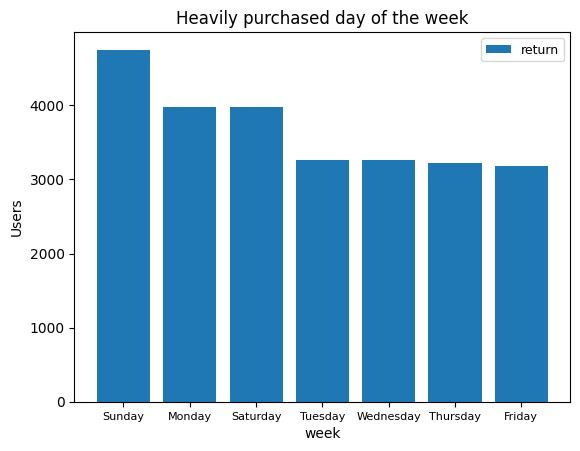

In [1208]:
# 요일 확인
def weekday_top(df):
    new_df = df[~((df['diff_day'] == pd.Timedelta(days=0)) & (df['customer_id'].diff() == 0))].copy() # 프로모션 중복 항목 제거
    df_name = [name for name in globals() if globals()[name] is df][0][2:]

    print(f'{df_name}:', list(df['weekday'].value_counts().index))

    week_value = new_df['weekday'].value_counts()

    if df_name == 'inactive':
        color = 'tab:orange'
    elif df_name == 'return':
        color = 'tab:blue'
    elif df_name == 'active':
        color = 'tab:green'
    elif df_name == 'new':
        color = 'tab:purple'

    plt.bar(week_value.index, week_value, label=df_name, color=color)

    plt.xlabel('week')
    plt.xticks(rotation=0, size=8)
    plt.ylabel('Users')
    plt.title('Heavily purchased day of the week')
    plt.legend(loc='upper right', prop={'size':9})
    plt.show()

weekday_top(c_return)
# weekday_top(c_inactive)
# weekday_top(c_active)
# weekday_top(c_new)

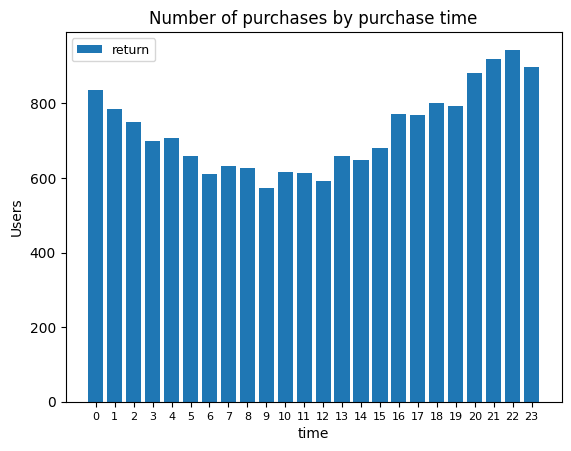

In [1207]:
# 구매시간
def time_purchase(df):

    purchase = df[(df['customer_id'].diff() == 0) & (df['created_at'].diff() > pd.Timedelta(days=0))].copy() # 재구매 정보
    purchase['created_h'] = purchase['created_h'].astype(str).str[:2].astype(int)

    result = purchase.groupby('created_h')['customer_id'].nunique()

    return result

def viz_time_purchase(df):
    new_df = df[~((df['diff_day'] == pd.Timedelta(days=0)) & (df['customer_id'].diff() == 0))].copy() # 프로모션 중복 항목 제거
    df_name = [name for name in globals() if globals()[name] is df][0][2:]

    if df_name == 'inactive':
        color = 'tab:orange'
    elif df_name == 'return':
        color = 'tab:blue'
    elif df_name == 'active':
        color = 'tab:green'
    elif df_name == 'new':
        color = 'tab:purple'

    plt.bar(time_purchase(df).index, time_purchase(df), label=df_name, color=color)

    plt.xlabel('time')
    plt.xticks(time_purchase(df).index, rotation=0, size=8)
    plt.ylabel('Users')
    plt.title('Number of purchases by purchase time')
    plt.legend(loc='upper left', prop={'size':9})
    plt.show()

viz_time_purchase(c_return)
# viz_time_purchase(c_inactive)
# viz_time_purchase(c_active)
# viz_time_purchase(c_new)

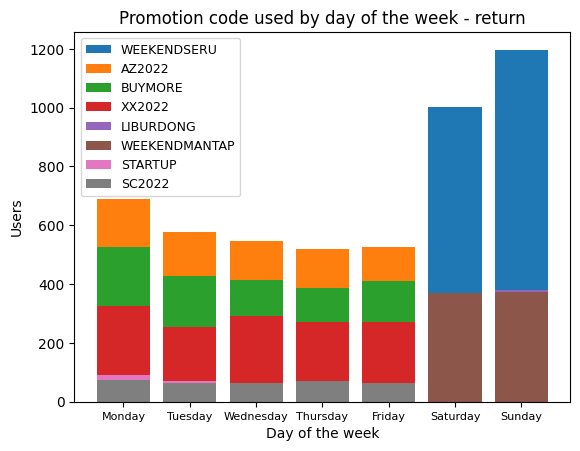

In [1132]:
def weekday_promo(df):
    
    total_amount = df[~((df['diff_day'] == pd.Timedelta(days=0)) & (df['customer_id'].diff() == 0))].copy() # total_amount 중복 항목 제거
    total_amount['created_m'] = total_amount['created_at'].astype(str).str[:7]
    
    result = total_amount.groupby(['weekday','promo_code'])['promo_code']

    week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    result_count = result.count().unstack(fill_value=np.nan).reindex(week)
    result_count = result_count[['WEEKENDSERU', 'AZ2022','BUYMORE', 'XX2022', 'LIBURDONG', 'WEEKENDMANTAP', 'STARTUP', 'SC2022']]

    return result_count

def vis_weekday_promo(df):
    df_name = [name for name in globals() if globals()[name] is df][0][2:]

    for category in weekday_promo(df).columns:
        plt.bar(weekday_promo(df).index, weekday_promo(df)[category], label=category)

    plt.xlabel('Day of the week')
    plt.xticks(rotation=0, size=8)
    plt.ylabel('Users')
    plt.title(f'Promotion code used by day of the week - {df_name}')
    plt.legend(loc='upper left', prop={'size':9})
    plt.show()

vis_weekday_promo(c_return)
# vis_weekday_promo(c_inactive)
# vis_weekday_promo(c_active)
# vis_weekday_promo(c_new)

In [ ]:
# 재구매 데이터 조회
def repurchase(df):
    repurchase = df[(df['customer_id'].diff() == 0) & (df['diff_day'] != pd.Timedelta(days=0))]
    three_times_ids = repurchase[repurchase['customer_id'].duplicated(keep=False)]['customer_id'].unique()
    three_times = df[df['customer_id'].isin(three_times_ids)]
    three_times = three_times[(three_times['customer_id'].diff() == 0) & (three_times['diff_day'] != pd.Timedelta(days=0))]
    three_times['items'] = df['product_id'].map(prod.set_index('id')['articleType'])

    return three_times

repurchase(c_inactive)

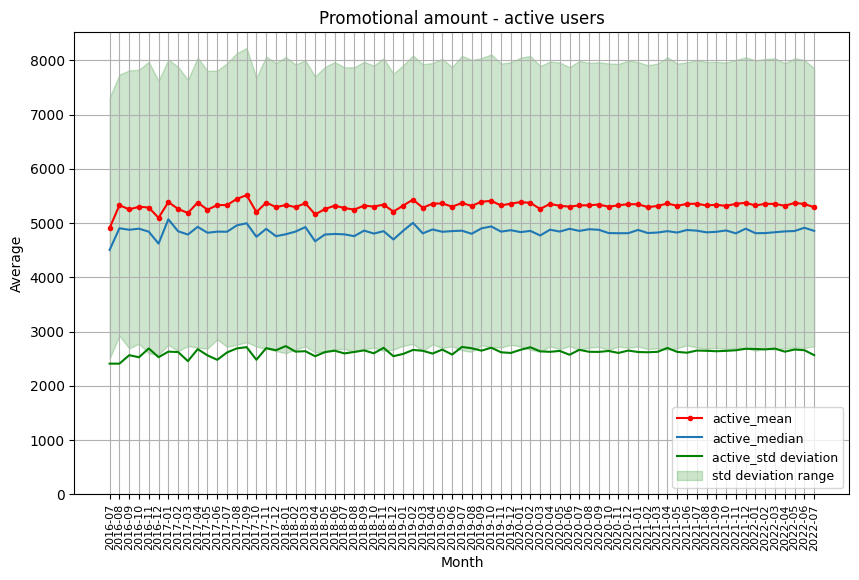

None

In [1240]:
# promo 사용 액수
def promo_amount(df):

    promo_count = df[~((df['diff_day'] == pd.Timedelta(days=0)) & (df['customer_id'].diff() == 0))].copy() # 프로모션 중복 항목 제거
    promo_count['created_m'] = promo_count['created_at'].astype(str).str[:7]

    promo_amount = promo_count[~promo_count['promo_code'].isnull()].groupby(['created_m'])['promo_amount']

    result_mean = promo_amount.mean()
    result_median = promo_amount.median()
    result_std = promo_amount.std()

# 2016-06 은 첫 시작 달이기 때문에 0 혹은 0에 가까운 숫자가 나온다. 분석에 큰 영향이 없으므로 삭제
    for results in [result_mean, result_median, result_std]:
        if '2016-06' in results.index:
            results.drop('2016-06', inplace=True)

    return result_mean, result_median, result_std

display(visualize_minusstd(c_active, promo_amount(c_active), 'Promotional amount'))
# display(visualize_minusstd(c_inactive, promo_amount(c_inactive), 'Promotional amount'))
# display(visualize_minusstd(c_new, promo_amount(c_new), 'Promotional amount'))
# display(visualize_minusstd(c_return, promo_amount(c_return), 'Promotional amount'))

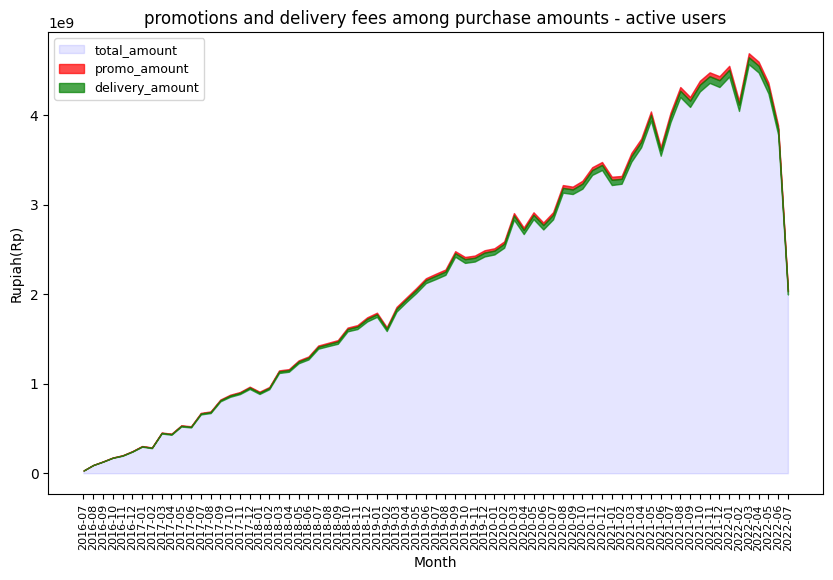

None

In [1241]:
# promo 사용 액수
def purchase(df):

    no_duplicated = df[~((df['diff_day'] == pd.Timedelta(days=0)) & (df['customer_id'].diff() == 0))].copy() # 프로모션 중복 항목 제거
    no_duplicated['created_m'] = no_duplicated['created_at'].astype(str).str[:7]

    total_amount = no_duplicated[~no_duplicated['promo_code'].isnull()].groupby(['created_m'])['total_amount'].sum()
    promo_amount = no_duplicated[~no_duplicated['promo_code'].isnull()].groupby(['created_m'])['promo_amount'].sum()    
    delivery_amount = no_duplicated[~no_duplicated['promo_code'].isnull()].groupby(['created_m'])['shipment_fee'].sum()

# 2016-06 은 첫 시작 달이기 때문에 0 혹은 0에 가까운 숫자가 나온다. 분석에 큰 영향이 없으므로 삭제
    for results in [total_amount, promo_amount, delivery_amount]:
        if '2016-06' in results.index:
            results.drop('2016-06', inplace=True)

    return total_amount, promo_amount, delivery_amount

def visualize_purchase(df, function_df, title):
    df_total, df_promo, df_delivery = function_df
    df_name = [name for name in globals() if globals()[name] is df][0][2:]

    # 1회 구매시 구매하는 아이템의 총 갯수(booking_id 기준)
    plt.figure(figsize=(10, 6))

    plt.fill_between(df_total.index, 0, df_total, color='blue', alpha=0.1, label='total_amount')
    plt.fill_between(df_promo.index, df_total-df_promo, df_total, color='red', alpha=0.7, label='promo_amount')
    plt.fill_between(df_delivery.index, df_total-df_promo-df_delivery, df_total-df_promo, color='green', alpha=0.7, label='delivery_amount')

    plt.xlabel('Month')
    plt.xticks(rotation=90, size=8)
    plt.ylabel('Rupiah(Rp)')
    # plt.ylim(0)
    plt.title(f'{title} - {df_name} users')
    plt.legend(loc='upper left', prop={'size':9})
    # plt.grid()
    plt.show()

display(visualize_purchase(c_active, purchase(c_active), 'promotions and delivery fees among purchase amounts'))
# display(visualize_purchase(c_inactive, purchase(c_inactive), 'promotions and delivery fees among purchase amounts'))
# display(visualize_purchase(c_new, purchase(c_new), 'promotions and delivery fees among purchase amounts'))
# display(visualize_purchase(c_return, purchase(c_return), 'promotions and delivery fees among purchase amounts'))